<a href="https://colab.research.google.com/github/vriteshg1210/data-512-homework_1/blob/main/DATA512_HW1_Using_the_API_for_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA512 - HW1: Professionalism and Reproducibility

##Project Name- Academy Award Winning Movies: Wikipedia Articles Monthly Traffic Analysis
by Vritesh Gera, University of Washington

 The main aim of this project is to analyse the monthly wikipedia page views of academy award winning movies. We do this by hiting the PageViews API provided by Wikimedia and gather information of these articles. The data coming back from the API would include the number of views, the name of the article, the mode through which it was accessed(mobile or desktop) along with a lot of other details. The time period for which this API sends the data is July 1,2015 till the last full month of the current year. In my case it would be September 30,2023

##1) Data Acquisition

As discussed, we will start by acquiring the data using the API mentioned above and creating list of dictionaries and finally dataframes of this data. The first step will be importing the python libraries which are necessary to run this program.

In [1]:
# These are standard python modules
import json, time, urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

In [2]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

I have uploaded the dataset to my Google drive and hence to access it, we will have to mount the driver in google colab. You can find the dataset here- https://docs.google.com/spreadsheets/d/1A1h_7KAo7KXaVxdScJmIVPTvjb3IuY9oZhNV4ZHxrxw/edit#gid=1229854301

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


These are some constants that help make the code a bit more readable.

In [4]:
#    CONSTANTS

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<vriteshg@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
#ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]
df_articles = pd.read_csv('/content/drive/My Drive/thank_the_academy.AUG.2023.csv')
#Sorting the list alphabetically
ARTICLE_TITLES = sorted(df_articles['name'].values)

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example below, we only vary the article name, so the majority of the fields
# can stay constant for each request. To make the API fetch data for various access types(desktop,mobile-web,mobile-app and all-access) we create
# different templates as seen below
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",
    "agent":       "user",
    "article":     "",             # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_ALL = {
    "project":     "en.wikipedia.org",
    "access":      "all-access",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [5]:
#    PROCEDURES/FUNCTIONS

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = None,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'),safe="")
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


Now in the next steps, we will create lists which will be a list of dictionaries containing details of the number of views for a particular timestamp and access type for each article. We will use the function we declared above to call the API and append the data into our list

#Desktop views

In [56]:
#Creating a list of desktop views for all the articles
desktop_list = []
for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  desktop_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
  try:
    remove_field = 'access'
    #We will now remove the 'access' field from all the dictionaries
    dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in desktop_article['items']]

    #New temp dictionary for making the article name as key
    temp_dict = {}
    for item in dicts_list:
      #Get the value of article key
      article_key = item['article']

      #Remove the article key from the dict
      del item['article']

      #Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      #Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    desktop_list.append(temp_dict)

  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

#Combined mobile views

As the mobile access is split into two- website and app- we will combine both of them to create just one list which adds both the types of views

In [57]:
#Creating a combined list of views for all mobile accessed articles
mobile_list = []

for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  mobile_web_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
  mobile_app_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)

  try:
    remove_field = 'access'
    #We will now remove the 'access' field from all the dictionaries
    mobile_web_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_web_article['items']]
    mobile_app_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_app_article['items']]

    # Iterate through the individual monthly data and add the monthly views for both web and app access
    for web_entry, app_entry in zip(mobile_web_dicts_list, mobile_app_dicts_list):
      web_entry['views'] = web_entry['views'] + app_entry['views']

    #New temp dictionary for making the article name as key
    temp_dict = {}
    for item in mobile_web_dicts_list:
      #Get the value of article key
      article_key = item['article']

      #Remove the article key from the dict
      del item['article']

      #Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      #Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    mobile_list.append(temp_dict)
  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

#Cumulative views i.e. Desktop+Mobile

In [58]:
#Creating a list of all-access views for all the articles
all_access_list = []
for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  cumulatve_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_ALL)
  try:
    remove_field = 'access'
    #We will now remove the 'access' field from all the dictionaries
    all_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in cumulatve_article['items']]

    #New temp dictionary for making the article name as key
    temp_dict = {}
    for item in all_dicts_list:
      #Get the value of article key
      article_key = item['article']

      #Remove the article key from the dict
      del item['article']

      #Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      #Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    all_access_list.append(temp_dict)
  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

Once all our lists are created i.e. mobile,desktop and cumulative, we will write them into external json files which will be stored into the drive from where we are accessing the dataset.

In [82]:
#Path for saving the desktop file
file_path_desktop = "academy_monthly_desktop_<start201501>-<end202309>.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_desktop, "w") as json_file:
    json.dump(desktop_list, json_file, indent=4)

In [83]:
#Path for saving the mobile file
file_path_mobile = "academy_monthly_mobile_<start201501>-<end202309>.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_mobile, "w") as json_file:
    json.dump(mobile_list, json_file, indent=4)

In [84]:
#Path for saving the cumulative file
file_path_cumulative = "academy_monthly_cummulative_<start201501>-<end202309>.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_cumulative, "w") as json_file:
    json.dump(all_access_list, json_file, indent=4)

These final output files are a list of dictionaries where each dictionary has the article name as the key. The values for this dictionary are a list of dictionaries with five key-value pairs - 'project', 'granularity', 'timestamp', 'agent', and 'views'. Except for 'views' which has integer values, all the other keys have string values.

Once we have the files ready, we will move on to the next task i.e. analysis. We will create dataframes out of the list of dictionaries we had created during the previous activity.

##2) Preprocessing and Analysis

First, we will convert the list of dictionaries to dataframes. We will do this for all 3 lists i.e. desktop, mobile and cumulative

In [59]:
#Creating dataframes from the desktop list
df_desktop = pd.DataFrame()

# Iterate through the data
for entry in desktop_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_desktop = df_desktop.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_desktop = df_desktop[column_order]

In [60]:
#Creating dataframes from the mobile list
df_mobile = pd.DataFrame()

# Iterate through the data
for entry in mobile_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_mobile = df_mobile.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_mobile = df_mobile[column_order]

In [61]:
#Creating dataframes from the cumulative list
df_cumulative = pd.DataFrame()

# Iterate through the data
for entry in all_access_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_cumulative = df_cumulative.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_cumulative = df_cumulative[column_order]

Next, we will pre-process the data by converting the timestamps to actual pytho timestamp datatype and removing the 'hours' values as its not needed.

In [62]:
# Omit the last two digits from the timestamp which represent the hours. We only need the year, month and date.
df_desktop['timestamp'] = df_desktop['timestamp'].str[:-2]
df_mobile['timestamp'] = df_mobile['timestamp'].str[:-2]
df_cumulative['timestamp'] = df_cumulative['timestamp'].str[:-2]

# Convert the timestamp column to datetime
df_desktop['timestamp'] = pd.to_datetime(df_desktop['timestamp'])
df_mobile['timestamp'] = pd.to_datetime(df_mobile['timestamp'])
df_cumulative['timestamp'] = pd.to_datetime(df_mobile['timestamp'])

We then drop the columns which are not relevant for our analysis

In [63]:
# Drop columns that are not relevant for analysis
df_desktop = df_desktop.drop(columns=['project','granularity','agent'], axis=1)
df_mobile = df_mobile.drop(columns=['project','granularity','agent'], axis=1)
df_cumulative = df_cumulative.drop(columns=['project','granularity','agent'], axis=1)

#a) Maximum Average and Minimum Average

This graph plots the time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access.

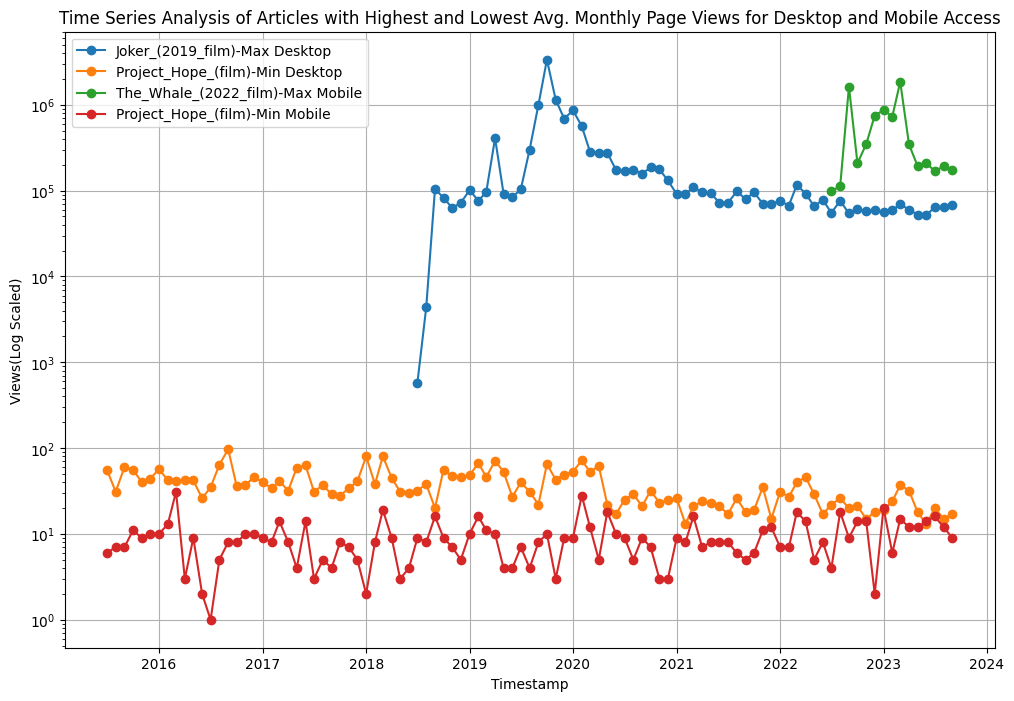

In [67]:
# Calculate average monthly page requests for each article
desktop_average_data = df_desktop.groupby(['article'])['views'].mean().reset_index()
mobile_average_data = df_mobile.groupby(['article'])['views'].mean().reset_index()


# Identify articles with the highest and lowest average monthly page requests for desktop and mobile
max_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmax()]
min_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmin()]
max_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmax()]
min_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmin()]

# Extract the corresponding monthly data of the four articles from desktop and mobile access dataframes
desktop_highest_data = df_desktop[df_desktop['article']==max_desktop['article']]
desktop_lowest_data = df_desktop[df_desktop['article']==min_desktop['article']]
mobile_highest_data = df_mobile[df_mobile['article']==max_mobile['article']]
mobile_lowest_data = df_mobile[df_mobile['article']==min_mobile['article']]

# Create a line graph
plt.figure(figsize=(12, 8))
label1 = max_desktop['article']
label2 = min_desktop['article']
label3 = max_mobile['article']
label4 = min_mobile['article']


plt.semilogy(desktop_highest_data['timestamp'], desktop_highest_data['views'], label=label1+'-Max Desktop', linestyle='-', marker='o')
plt.semilogy(desktop_lowest_data['timestamp'], desktop_lowest_data['views'], label=label2+'-Min Desktop', linestyle='-', marker='o')
plt.semilogy(mobile_highest_data['timestamp'], mobile_highest_data['views'], label=label3+'-Max Mobile', linestyle='-', marker='o')
plt.semilogy(mobile_lowest_data['timestamp'], mobile_lowest_data['views'], label=label4+'-Min Mobile', linestyle='-', marker='o')

plt.xlabel('Timestamp')
plt.ylabel('Views(Log Scaled)')
plt.title('Time Series Analysis of Articles with Highest and Lowest Avg. Monthly Page Views for Desktop and Mobile Access')
plt.legend()
plt.grid(True)

plt.show()


The analysis reveals that 'Joker (2019)' and 'The Whale (2022)' stand out as the top performers in terms of monthly average views, with 'Joker' dominating desktop access and 'The Whale' leading in mobile access.

However, it's noteworthy that 'The Whale,' being a more recent release, exhibits a shorter time frame of data with intermittent peaks. In contrast, 'Joker' boasts a longer data history, characterized by a single, substantial peak.

On the flip side, 'Project Hope' ranks at the bottom in terms of monthly average views for both desktop and mobile access. Its viewership trend is marked by frequent fluctuations, featuring numerous peaks and drops.

### (b) Top 10 Peak Page Views

The following graph contains time series data for the top 10 article pages by largest (peak) page views over the entire time by access type.

In [68]:
df_sorted_desktop_views = df_desktop.sort_values(by='views',ascending = False).reset_index(drop=True)
df_sorted_mobile_views = df_mobile.sort_values(by='views',ascending = False).reset_index(drop=True)

In [69]:
# Picking out the top 10 articles with the most views for desktop and mobile
df_desktop_top10_views = df_sorted_desktop_views[:10]
df_mobile_top10_views = df_sorted_mobile_views[:10]

In [70]:
# Finding out the months when the articles have peak views
df_desktop_top10_views['peak_month'] = df_desktop_top10_views['timestamp'].apply(lambda x: x.month)
df_mobile_top10_views['peak_month'] = df_mobile_top10_views['timestamp'].apply(lambda x: x.month)

In [71]:
# Retrieve the article names of the top 10 rows which represent the movies with largest page views to check if there are any duplicates
desktop_top10_articles = df_desktop_top10_views['article'].tolist()
mobile_top10_articles = df_mobile_top10_views['article'].tolist()

In [72]:
desktop_top10_articles

['Joker_(2019_film)',
 'Parasite_(2019_film)',
 'Black_Panther_(film)',
 'The_Revenant_(2015_film)',
 'Avatar:_The_Way_of_Water',
 'Spectre_(2015_film)',
 'Dune_(2021_film)',
 '1917_(2019_film)',
 'Tenet_(film)',
 'Blade_Runner_2049']

In [73]:
mobile_top10_articles

['Avatar:_The_Way_of_Water',
 'Joker_(2019_film)',
 'Black_Panther_(film)',
 'Parasite_(2019_film)',
 'Avatar:_The_Way_of_Water',
 'Black_Panther:_Wakanda_Forever',
 'RRR_(film)',
 'Dune_(2021_film)',
 'The_Revenant_(2015_film)',
 'Top_Gun:_Maverick']

We can see that the movie 'Avatar: The Way of Water' repeats in the Top 10 list for the access type mobile. With the assumption that the movie names have to be unique, the top 10 unique movies have been selected in the step below for the access type mobile.

In [74]:
# Retrieve the Top 10 unique articles and the month for each article that contains the highest page views
mobile_top10 = df_sorted_mobile_views.drop_duplicates(['article']).head(10)
mobile_top10['peak_month'] = mobile_top10['timestamp'].apply(lambda x: x.month)

In [76]:
#Retrieving the name of the top 10 mobile accessed articles again. These won't have any duplicates
mobile_top10_articles = mobile_top10['article'].tolist()
mobile_top10_articles

['Avatar:_The_Way_of_Water',
 'Joker_(2019_film)',
 'Black_Panther_(film)',
 'Parasite_(2019_film)',
 'Black_Panther:_Wakanda_Forever',
 'RRR_(film)',
 'Dune_(2021_film)',
 'The_Revenant_(2015_film)',
 'Top_Gun:_Maverick',
 'Everything_Everywhere_All_at_Once']

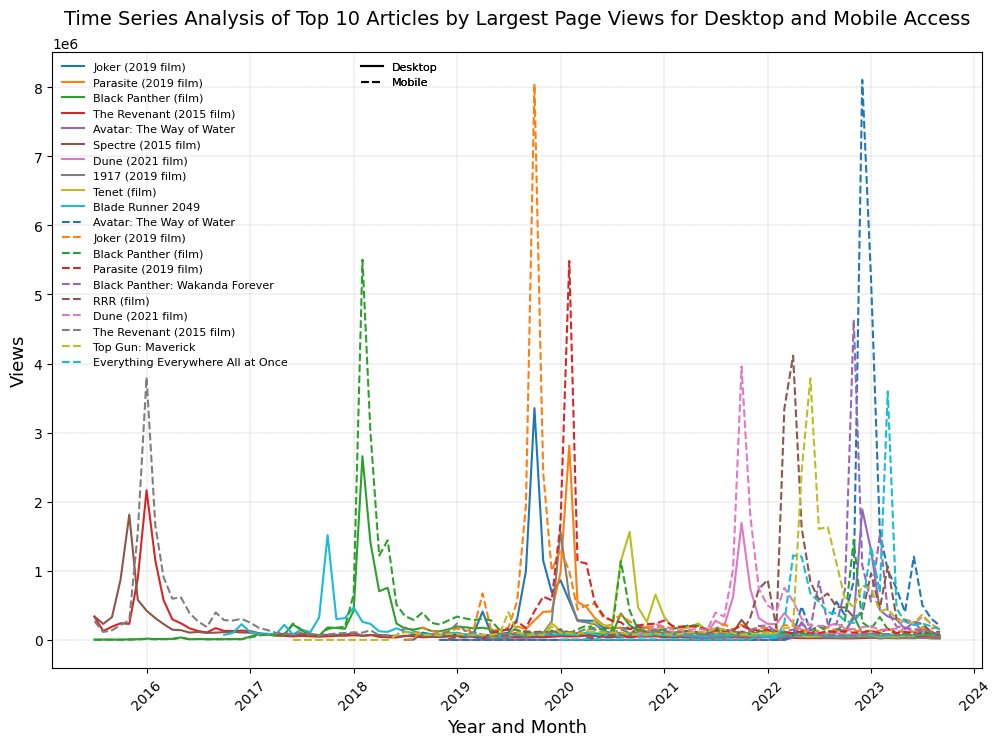

In [77]:
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Create a figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Iterate through all the articles in desktop and mobile to plot the views as a timeseries graph
for desktop_article in desktop_top10_articles:
    desktop_article_result = df_desktop[df_desktop['article'] == desktop_article]
    ax.plot(desktop_article_result['timestamp'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_', ' '))

for mobile_article in mobile_top10_articles:
    mobile_article_result = df_mobile[df_mobile['article'] == mobile_article]
    ax.plot(mobile_article_result['timestamp'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_', ' '))


# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Analysis of Top 10 Articles by Largest Page Views for Desktop and Mobile Access', pad=20,
          fontsize=14)

# The first legend below represents all the article names
legend1 = plt.legend(loc='upper left', prop={"size": 8}, frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 1), prop={"size": 8},
                    frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()


The above plot has twenty line graphs - Top 10 articles by largest page views for desktop and mobile respectively. It can be observed that the peaks for the mobile views are higher than that of desktop. All the peaks are also clustered into roughly four groups which seems pretty interesting.

### (c) Fewest Months of Data

The concluding graph highlights pages with the shortest available data history, encompassing both desktop and mobile access types. These represent relatively brief time series and encompass some of the latest Academy Award-winning content.

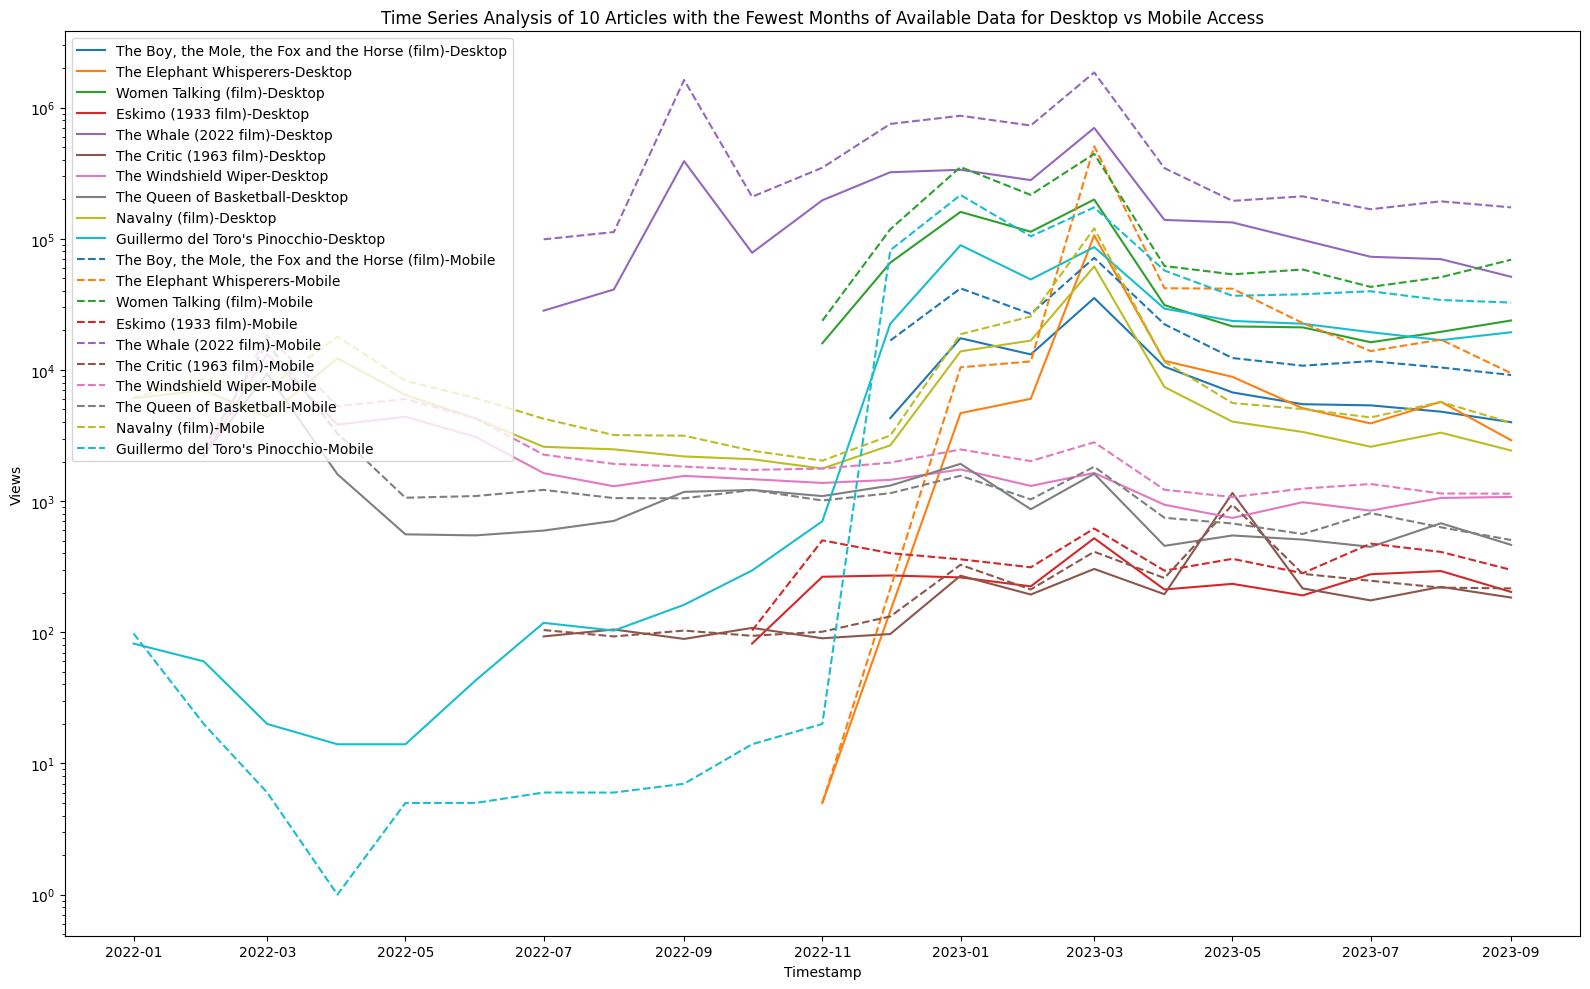

In [95]:
# Group by article and access, and count the number of unique months
article_counts_desktop = df_desktop.groupby(['article'])['timestamp'].nunique().reset_index()
article_counts_mobile = df_mobile.groupby(['article'])['timestamp'].nunique().reset_index()

# Sort by the number of unique months
article_counts_desktop = article_counts_desktop.sort_values(by='timestamp')
article_counts_mobile = article_counts_mobile.sort_values(by='timestamp')

# Get the 10 articles with the fewest months of data for desktop and mobile access
desktop_articles_least_10 = article_counts_desktop[:10]
mobile_articles_least_10 = article_counts_mobile[:10]

# Create line charts for the selected articles
plt.figure(figsize=(16, 10))

for index, row in desktop_articles_least_10.iterrows():
    article_data = df_desktop[(df_desktop['article'] == row['article'])]
    plt.semilogy(article_data['timestamp'], article_data['views'], linestyle='-',
            label=desktop_articles_least_10['article'][index].replace('_',' ')+'-Desktop')

for index, row in mobile_articles_least_10.iterrows():
    article_data = df_mobile[(df_mobile['article'] == row['article'])]
    plt.semilogy(article_data['timestamp'], article_data['views'], linestyle='--',
            label=mobile_articles_least_10['article'][index].replace('_',' ')+'-Mobile')

plt.title('Time Series Analysis of 10 Articles with the Fewest Months of Available Data for Desktop vs Mobile Access')
plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


The concluding graph highlights pages with the shortest available data history, encompassing both desktop and mobile access types. These represent relatively brief time series and encompass some of the latest Academy Award-winning content.

##3) Result

In summary, we constructed three graphs using monthly article traffic data for English Wikipedia articles related to Academy Award-winning movies, spanning from July 1, 2015, to September 30, 2023. These visualizations provided insights into the data's trends and patterns.

The first graph delved into the time series relationship between articles with the highest and lowest average monthly page requests for both desktop and mobile access. Notably, 'Joker (2019)' had the highest monthly average views for desktop access, while 'The Whale (2022)' claimed the top spot for mobile access. Conversely, 'Project Hope' had the lowest monthly average views for both access types.

The second graph featured time series data for the top 10 articles with the largest page views, categorized by access type. Remarkably, mobile views consistently outperformed desktop views in terms of peaks, and these peaks clustered into approximately four distinct groups.

The third graph spotlighted articles with the shortest available data histories for both desktop and mobile access. These line graphs represented relatively brief time series and centered around recent Academy Award-winning content. Overall, a similar trend was observed across articles for both mobile and desktop views.